# MNIST Training with Random Number.

In [1]:
! nvidia-smi

Fri May 21 16:39:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Packages

In [19]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Dataset Class Extension

In [3]:
from torchvision.datasets import MNIST
import numpy as np
class MyDataset(MNIST):

    def __init__(self, *args, **kwargs):
        super(MyDataset, self).__init__(*args, **kwargs)
        
    def __getitem__(self, index):
        img, target = super(self.__class__, self).__getitem__(index)
        random_number = np.random.randint(low=0, high=10)
        return (img, random_number), (target, target + random_number)

## Customized MNIST Data Set

In [4]:
train_dataset = MyDataset('../data',train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
test_dataset = MyDataset('../data',train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

## Network Structure

In [5]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, padding=1),nn.BatchNorm2d(8))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv4 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=1),nn.BatchNorm2d(16),nn.Dropout(0.23))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(16, 32, 3)
        self.conv6 = nn.Conv2d(32, 32, 3)
        self.conv7 = nn.Conv2d(32, 10, 3)
        self.adder_layer1 = nn.Sequential(nn.Linear(in_features=20, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
        self.adder_layer2 = nn.Sequential(nn.Linear(in_features=60, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
        self.adder_layer3 = nn.Sequential(nn.Linear(in_features=60, out_features=19, bias=False))


    def forward(self, x, y):
        y = F.one_hot(y, num_classes=self.num_classes)
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        y = torch.cat([x, y], dim=-1)
        y = self.adder_layer1(y)
        y = self.adder_layer2(y)
        y = self.adder_layer3(y)
        return F.log_softmax(x), F.log_softmax(y)

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(num_classes = 10).to(device)
# summary(model, input_size=[(1, 28, 28),7])

## MNIST Data Loader

In [7]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

## Train and Test Module

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        (mnist_x, rand_num) = data
        (mnist_y, final_y) = target
        mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
        optimizer.zero_grad()
        mnist_pred, final_pred = model(mnist_x, rand_num)
        mnist_loss = F.nll_loss(mnist_pred, mnist_y)
        adder_loss = F.nll_loss(final_pred, final_y)
        loss = mnist_loss + adder_loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()}, MNIST_LOSS={mnist_loss.item()}, ADDER_LOSS={adder_loss.item()}, batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    mnist_correct = 0
    adder_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            (mnist_x, rand_num) = data
            (mnist_y, final_y) = target
            mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
            mnist_pred, final_pred = model(mnist_x, rand_num)
            mnist_loss = F.nll_loss(mnist_pred, mnist_y)
            adder_loss = F.nll_loss(final_pred, final_y)
            loss = mnist_loss + adder_loss
            mnist_pred = torch.argmax(mnist_pred, dim=1)
            final_pred = torch.argmax(final_pred, dim=1)
            test_loss += loss.item()  # sum up batch loss
            mnist_correct += mnist_pred.eq(mnist_y.view_as(mnist_pred)).sum().item()
            adder_correct += final_pred.eq(final_y.view_as(final_pred)).sum().item()


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, MNIST_Accuracy: {}/{} ({:.2f}%), ADDER_Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, mnist_correct, len(test_loader.dataset), 100. * mnist_correct / len(test_loader.dataset), 
        adder_correct, len(test_loader.dataset), 100. * adder_correct / len(test_loader.dataset)))

## Epochs Process

In [9]:
model = Net(num_classes = 10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=1.1576958894729614, MNIST_LOSS=0.1674126833677292, ADDER_LOSS=0.990283191204071, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, MNIST_Accuracy: 9559/10000 (95.59%), ADDER_Accuracy: 9019/10000 (90.19%)



loss=0.4287705719470978, MNIST_LOSS=0.112477146089077, ADDER_LOSS=0.3162934184074402, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, MNIST_Accuracy: 9863/10000 (98.63%), ADDER_Accuracy: 9831/10000 (98.31%)



loss=0.32282382249832153, MNIST_LOSS=0.102923683822155, ADDER_LOSS=0.21990014612674713, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, MNIST_Accuracy: 9896/10000 (98.96%), ADDER_Accuracy: 9872/10000 (98.72%)



loss=0.1353697031736374, MNIST_LOSS=0.03294793888926506, ADDER_LOSS=0.10242176055908203, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, MNIST_Accuracy: 9920/10000 (99.20%), ADDER_Accuracy: 9891/10000 (98.91%)



loss=0.07337716221809387, MNIST_LOSS=0.0168799739331007, ADDER_LOSS=0.05649719014763832, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, MNIST_Accuracy: 9853/10000 (98.53%), ADDER_Accuracy: 9842/10000 (98.42%)



loss=0.07298686355352402, MNIST_LOSS=0.025381339713931084, ADDER_LOSS=0.04760552570223808, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9930/10000 (99.30%), ADDER_Accuracy: 9904/10000 (99.04%)



loss=0.030107539147138596, MNIST_LOSS=0.010075696744024754, ADDER_LOSS=0.020031841471791267, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, MNIST_Accuracy: 9919/10000 (99.19%), ADDER_Accuracy: 9895/10000 (98.95%)



loss=0.14066626131534576, MNIST_LOSS=0.030183425173163414, ADDER_LOSS=0.1104828417301178, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9935/10000 (99.35%), ADDER_Accuracy: 9903/10000 (99.03%)



loss=0.11490893363952637, MNIST_LOSS=0.01450982317328453, ADDER_LOSS=0.10039911419153214, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9917/10000 (99.17%), ADDER_Accuracy: 9897/10000 (98.97%)



loss=0.11564531922340393, MNIST_LOSS=0.025908373296260834, ADDER_LOSS=0.0897369459271431, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9922/10000 (99.22%), ADDER_Accuracy: 9906/10000 (99.06%)



loss=0.09489831328392029, MNIST_LOSS=0.04964553192257881, ADDER_LOSS=0.045252781361341476, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9921/10000 (99.21%), ADDER_Accuracy: 9904/10000 (99.04%)



loss=0.12428296357393265, MNIST_LOSS=0.024270862340927124, ADDER_LOSS=0.10001210123300552, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9933/10000 (99.33%), ADDER_Accuracy: 9924/10000 (99.24%)



loss=0.1224784329533577, MNIST_LOSS=0.04778026044368744, ADDER_LOSS=0.07469817250967026, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9934/10000 (99.34%), ADDER_Accuracy: 9916/10000 (99.16%)



loss=0.05940427631139755, MNIST_LOSS=0.028431549668312073, ADDER_LOSS=0.03097272664308548, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9941/10000 (99.41%), ADDER_Accuracy: 9925/10000 (99.25%)



loss=0.03830946236848831, MNIST_LOSS=0.007708704099059105, ADDER_LOSS=0.030600758269429207, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9936/10000 (99.36%), ADDER_Accuracy: 9932/10000 (99.32%)



loss=0.010783478617668152, MNIST_LOSS=0.004328254610300064, ADDER_LOSS=0.0064552235417068005, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9940/10000 (99.40%), ADDER_Accuracy: 9932/10000 (99.32%)



loss=0.01817721128463745, MNIST_LOSS=0.004376142751425505, ADDER_LOSS=0.013801068998873234, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9940/10000 (99.40%), ADDER_Accuracy: 9933/10000 (99.33%)



loss=0.02124529704451561, MNIST_LOSS=0.004314279183745384, ADDER_LOSS=0.016931017860770226, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9938/10000 (99.38%), ADDER_Accuracy: 9931/10000 (99.31%)



loss=0.04506538808345795, MNIST_LOSS=0.01459500566124916, ADDER_LOSS=0.030470384284853935, batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]



Test set: Average loss: 0.0005, MNIST_Accuracy: 9933/10000 (99.33%), ADDER_Accuracy: 9921/10000 (99.21%)



## Plotting Results

In [10]:
def infer_and_plot_output(sample_data, model):
    (mnist_img, adder_num), (mnist_target, adder_target) = sample_data
    
    with torch.no_grad():
        mnist_pred, adder_pred = model(mnist_img, adder_num)
        mnist_pred, adder_pred = torch.argmax(mnist_pred, dim=1), torch.argmax(adder_pred, dim=1)

    num_images = 25
    fig = plt.figure(figsize=(12, 15))

    assert len(mnist_img[0] >= 25), "need atleast 25 images in `sample_data`"

    fig.suptitle('MNIST Adder')

    for idx in range(0, 25):

        image = mnist_img[idx].cpu().numpy()
        add_num = adder_num[idx].cpu().item()
        image_target = mnist_target[idx].cpu().item()
        add_target = adder_target[idx].cpu().item()
        image_pred = mnist_pred[idx].cpu().item()
        add_pred = adder_pred[idx].cpu().item()

        isvalid = (image_target == image_pred) and (add_target == add_pred)
        isvalid = str(isvalid).upper()

        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.imshow(mnist_img[idx].squeeze())
        ax.set_title(f'target: {image_target} + {add_num} = {add_target}\npred: {image_pred} + {add_num} = {add_pred}\nValid: {isvalid}')

    plt.show()

In [21]:
plotting_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True, **kwargs)
data = iter(plotting_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


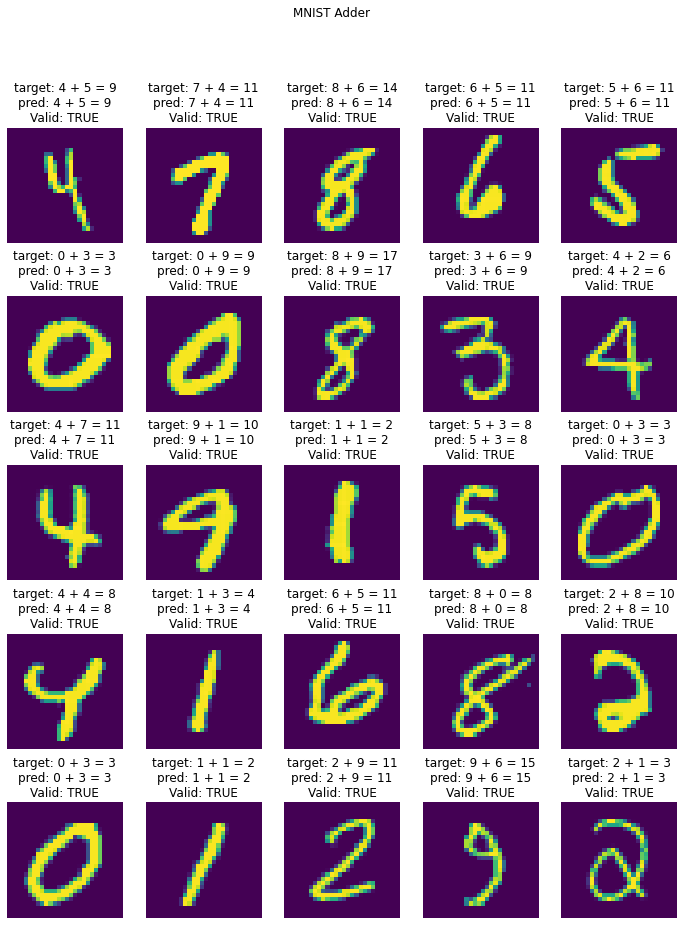

In [22]:
infer_and_plot_output(next(data),model.to('cpu'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


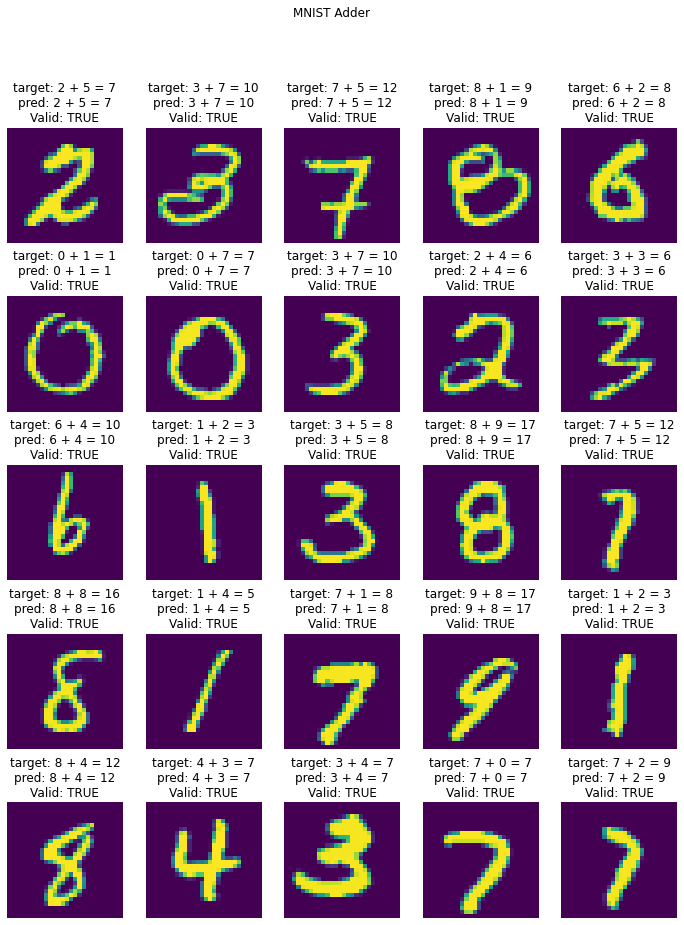

In [23]:
infer_and_plot_output(next(data),model.to('cpu'))